<a href="https://colab.research.google.com/github/almarengo/gpt2-text-classification/blob/main/GPT2_Transfer_Learning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using GPT2 and Tensorflow

In this notebook we will classify the tweets (sentiment analysis) like we did in this other project [COVID Tweets Analysis](https://github.com/almarengo/COVID_Tweet_Analysis).

In this project, Notebook 3 we used logistic regression and random forest. The dataset can be found in the same repository.

We will see if fine-tuning a pre-trained model (GPT2) will give us better accurancies.

Let's start dowloading Hugging Face's Transformers.

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 34.9 MB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 20.2 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Let's import the packages. We will use Tensorflow for this project.

In [ ]:
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

We'll read the tweet file


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Data Science/data/tweets_processed.csv')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df.columns

Index(['lemmatized_tweets', 'VADER_sentiment'], dtype='object')

Split it into train and test.

In [ ]:
X = df['lemmatized_tweets']
y = df['VADER_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
X_train

1033      africa cdc will ask all covid vaccine donati...
444     the overall risk of develop mycocarditis after...
1288    collab team from amp fund by covid vaccine tea...
1170      over of india 's adult population be now ful...
1433    how important can dendritic cell therapy be fo...
                              ...                        
475     the vaccine bus will be at webheath palmerston...
1101    do we all have to get shot regularly now the a...
1453    I talk with yet another friend who lose a pare...
843     what these blowhard fail to realize be that th...
957     covid in pregnancy in scotland study reveal su...
Name: lemmatized_tweets, Length: 1569, dtype: object

We will assign the max length of the sequence as the average length of all the tweets + 2 (arbitrary)

In [ ]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

27

Let's initialize the tokenizer and add a PAD token ane and EOS (end of text) token

In [ ]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We add the EOS token at the end of each tweet

In [ ]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

We pass the tweets through the tokenizer, padding them to the max_length. This is a list so we need to stack them to create a tensor input (using tf.convert_to_tensor)

In [ ]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
X_train_in[0]

<tf.Tensor: shape=(27,), dtype=int32, numpy=
array([  220,  6580, 30997,   269, 17896,   481,  1265,   477, 39849,
         312, 12319, 13784,   307, 14985,  1566,   374,    67,   393,
         294,  3860,   286,   428,   614,   275,   269,  4165,  4427],
      dtype=int32)>

We will also get the mask from the tokenizer (1 is token, 0 is pad token) the same we did for the inputs.

In [ ]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


We are now ready to pass the inputs through the model.
Next we need to initilize GPT2 for TF and set it in training mode.

In [ ]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
model.resize_token_embeddings(len(tokenizer))

Set the GPT2 pre-trained layers as non trainable

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________


Next we build on top of GPT2.
The model takes in tokens and mask tensors. The outputs are the last hidden states of the last layer in the transformer. These are reduced using the mean over the sequence length, passed through 2 dense layers with dopout in between. The output layer has three node (softmax activation function for probabilities) for the three classes we want to predict (Negative, Neutral and Positive).

In [ ]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
clf = tf.keras.Model([input, mask], output)

In [ ]:
clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                           

Next we compile the model choosing the learning rate, loss function and the metric to monitor. Also a callback function.

In [ ]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#loss=tf.keras.losses.BinaryCrossentropy()
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)

Last thing we need to do is preparing the target tensor.

In [ ]:
def map_sentiment(value):
  if value == 'Negative':
    return 0
  if value == 'Neutral':
    return 1
  if value == 'Positive':
    return 2

In [ ]:
y_train_ = y_train.map(map_sentiment)
y_test_ = y_test.map(map_sentiment)

In [ ]:
y_train_in = tf.constant(y_train_, dtype=tf.int32)
y_test_in = tf.constant(y_test_, dtype=tf.int32)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


We then train the model passing number of epochs, batch_size and validation split.

In [ ]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


40/40 [==============================] - 496s 12s/step - loss: 4.7046 - accuracy: 0.3625 - val_loss: 1.6923 - val_accuracy: 0.4809
Epoch 2/30
40/40 [==============================] - 493s 12s/step - loss: 2.6448 - accuracy: 0.4120 - val_loss: 1.0724 - val_accuracy: 0.5064
Epoch 3/30
40/40 [==============================] - 497s 12s/step - loss: 1.4117 - accuracy: 0.4765 - val_loss: 0.9622 - val_accuracy: 0.5096
Epoch 4/30
40/40 [==============================] - 500s 13s/step - loss: 0.9828 - accuracy: 0.5307 - val_loss: 0.9714 - val_accuracy: 0.5159
Epoch 5/30
40/40 [==============================] - 510s 13s/step - loss: 0.9151 - accuracy: 0.5649 - val_loss: 0.9340 - val_accuracy: 0.5255
Epoch 6/30
40/40 [==============================] - 505s 13s/step - loss: 0.8658 - accuracy: 0.5809 - val_loss: 0.9015 - val_accuracy: 0.5510
Epoch 7/30
40/40 [==============================] - 509s 13s/step - loss: 0.8396 - accuracy: 0.6143 - val_loss: 0.8887 - val_accuracy: 0.5446
Epoch 8/30
40/40 

We can now evaluate the model on the test set.

In [ ]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


17/17 [==============================] - 58s 3s/step - loss: 1.0816 - accuracy: 0.6469


[1.0816469192504883, 0.6469465494155884]

In [ ]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(524,), dtype=int64, numpy=
array([2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2,
       0, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2,
       2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 2, 1,
       2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 0, 1,
       2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 2, 1,
       1, 2, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 0,
       1, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2,
       1, 2, 0, 2, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2,
       2, 1, 0, 1, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 2, 0,
       0, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 0, 1, 1, 0, 2,
     

We can now evaluate the model on the test set using the classification report and confusion matrix.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       134
           1       0.76      0.60      0.67       183
           2       0.60      0.75      0.67       207

    accuracy                           0.65       524
   macro avg       0.66      0.63      0.64       524
weighted avg       0.66      0.65      0.65       524



We notice right away that the model, overall, has a good precision and recall on all classes. The model has more difficulties in predicting the negative class (0), expecially recall.

Of all the predicted negative, 60% were actually negative - the model has a decent precision. Of all the ones that were actually negative, only 56% were predicted negative - the model struggles recalling (recall metric) the negative class.

Below is the confusion matrix that helps understand it better.

In [ ]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['Actual -1', 'Actual 0', 'Actual 1']
confusion_df.columns = ['Predicted -1', 'Predicted 0', 'Predicted 1']
confusion_df

,Predicted -1,Predicted 0,Predicted 1
Actual -1,75,13,46
Actual 0,18,109,56
Actual 1,31,21,155


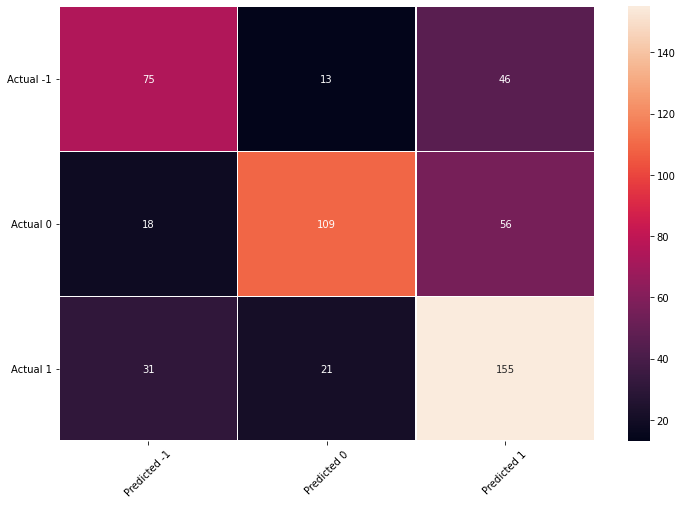

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

Overall the model doesn't seem to outperform logistic regression and random forest. 
It's worth noticing that the model is overfitting so it would be nice to re-train it, playing with learning rate, weight decay and dropout rate.  

In [ ]:
clf.save_weights('/content/gdrive/My Drive/Data Science/saved_model/GPT2_transfer_learning')